In [1]:
import modin.pandas as pd

from cryptsmash.utils import inv_chi_squared, frequency_table, index_of_coincidence
from cryptsmash.plaintext import English

In [2]:
with open("wikisent2.txt", 'r') as f:
    sentences = f.read().split("\n")

df = pd.DataFrame(sentences, columns=['plaintext'])
alphabet = set(['\n'])
# cat old-newspaper.tsv| awk -F "\t" '{if($1=="English"){print $4}}' | tee english-newspaper.txt
with open("english-newspaper.txt", 'r', newline='') as f:
    data = f.read().split("\n")

data = data

for sentence in data:
    for char in sentence:
        alphabet.add(char)

df = pd.concat([pd.DataFrame({'plaintext': data}),  ], ignore_index=True)

# Clean up some stuffs
del sentences
del sentence
del data


2024-01-21 21:35:39,564	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init()

2024-01-21 21:35:41,956	INFO worker.py:1724 -- Started a local Ray instance.
(raylet) [2024-01-21 21:40:41,913 E 16234 16234] (raylet) node_manager.cc:3022: 3 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 893369aba5ad093bcdbf2fc8f5e673b1fb8829de9380a7e77493d55f, IP: 10.0.10.157) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 10.0.10.157`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task p

In [3]:
df['plain_len'] = df.apply(lambda r: len(r['plaintext']), axis=1)
# At least 5 letter cipher (which is pretty short anyways)
df = df[df['plain_len'] > 4]



In [4]:
df['plain_chisq'] = df.apply(lambda r: inv_chi_squared(frequency_table(r['plaintext']), English.byte_distro, r['plain_len']), axis=1)
df['plain_ioc'] = df.apply(lambda r: index_of_coincidence(r['plaintext']), axis=1)
# df.head()

In [5]:
df.describe().apply(lambda s: s.apply(lambda x:format(x,'f')))

,plain_len,plain_chisq,plain_ioc
count,1009808.000000,1009808.000000,1009808.000000
mean,202.352052,0.002670,0.062382
std,133.547487,0.003913,0.011326
min,5.000000,0.000024,0.000000
25%,111.000000,0.000999,0.059226
50%,186.000000,0.001444,0.063966
75%,269.000000,0.002418,0.067953
max,11384.000000,0.051053,1.000000


In [6]:
df.head()

,plaintext,plain_len,plain_chisq,plain_ioc
0,"He wasn't home alone, apparently.",33,0.008086,0.047348
1,The St. Louis plant had to close. It would die...,153,0.001755,0.066993
2,WSU's plans quickly became a hot topic on loca...,177,0.001517,0.063238
3,The Alaimo Group of Mount Holly was up for a c...,498,0.000540,0.066455
4,And when it's often difficult to predict a law...,246,0.001092,0.067994


In [7]:
import random
random.seed(1337)

# Transposition Ciphers
from cryptsmash import railfence

df['railfence'] = df.apply(lambda r: railfence.encrypt(r['plaintext'], random.randint(2, r['plain_len']-1)), axis=1)

# Should look the same since these stats don't take into account order
df['railfence_chisq'] = df.apply(lambda r: inv_chi_squared(frequency_table(r['railfence']), English.byte_distro, len(r['railfence'])), axis=1)
df['railfence_ioc'] = df.apply(lambda r: index_of_coincidence(r['railfence']), axis=1)

df.drop(['railfence'], axis=1, inplace=True)

In [8]:
import string

# Monoalphabetic Substitutions
from cryptsmash import affine
import numpy as np

def rnd_key(size):
    a = random.randint(1, size-1)
    while np.gcd(a, size) != 1:
        a = random.randint(1, size-1)
    
    return a, random.randint(0, size-1)

df['affine'] = df.apply(lambda r: affine.encrypt(r['plaintext'], rnd_key(len(r['plaintext'])), alphabet=string.printable), axis=1)
df['affine_chisq'] = df.apply(lambda r: inv_chi_squared(frequency_table(r['affine']), English.byte_distro, len(r['affine'])), axis=1)
df['affine_ioc'] = df.apply(lambda r: index_of_coincidence(r['affine']), axis=1)
df.drop(['affine'], axis=1, inplace=True)

In [9]:
from cryptsmash import substitution

def rnd_key(alphabet):
    d = dict()
    for k,v in zip(alphabet, random.sample(alphabet, k=len(alphabet))):
        d[k] = v
    return d

df['sub'] = df.apply(lambda r:substitution.encrypt(r['plaintext'], rnd_key(string.printable)), axis=1)
df['sub_chisq'] = df.apply(lambda r: inv_chi_squared(frequency_table(r['sub']), English.byte_distro, len(r['sub'])), axis=1)
df['sub_ioc'] = df.apply(lambda r:index_of_coincidence(r['sub']), axis=1)
df.drop(['sub'], axis=1, inplace=True)

In [10]:
# Polyalphabetic Substitions
from cryptsmash import vigenere
from faker import Faker
Faker.seed(1337)
faker = Faker()

df['vigenere'] = df.apply(lambda r: vigenere.encrypt(r['plaintext'], faker.word(), alphabet), axis=1)
df['vigenere_chisq'] = df.apply(lambda r: inv_chi_squared(frequency_table(r['vigenere']), English.byte_distro, len(r['vigenere']), [bytes(a,'utf8') for a  in alphabet]), axis=1)
df['vigenere_ioc'] = df.apply(lambda r:index_of_coincidence(r['vigenere']), axis=1)
df.drop(['vigenere'], axis=1, inplace=True)
df.describe().apply(lambda s: s.apply(lambda x:format(x,'f')))

,plain_len,plain_chisq,plain_ioc,railfence_chisq,railfence_ioc,affine_chisq,affine_ioc,sub_chisq,sub_ioc,vigenere_chisq,vigenere_ioc
count,1009808.000000,1009808.000000,1009808.000000,1009808.000000,1009808.000000,1009808.000000,1009808.000000,1009808.000000,1009808.000000,1009808.000000,1009808.000000
mean,202.352052,0.002670,0.062382,0.002670,0.062382,0.002670,0.083711,0.002670,0.062382,0.001098,0.018176
std,133.547487,0.003913,0.011326,0.003913,0.011326,0.003913,0.074502,0.003913,0.011326,0.001624,0.006706
min,5.000000,0.000024,0.000000,0.000024,0.000000,0.000024,0.000000,0.000024,0.000000,0.000010,0.000000
25%,111.000000,0.000999,0.059226,0.000999,0.059226,0.000999,0.061404,0.000999,0.059226,0.000409,0.014293
50%,186.000000,0.001444,0.063966,0.001444,0.063966,0.001444,0.066667,0.001444,0.063966,0.000591,0.017392
75%,269.000000,0.002418,0.067953,0.002418,0.067953,0.002418,0.073118,0.002418,0.067953,0.000990,0.021228
max,11384.000000,0.051053,1.000000,0.051053,1.000000,0.051053,1.000000,0.051053,1.000000,0.021535,0.329670


In [26]:
# XOR is techinicaly a polyalphabetic sub?
from cryptsmash import xor

df['xor'] = df.apply(lambda r: xor.encrypt(bytes(r['plaintext'], 'utf8'), bytes(faker.word(), 'utf8')), axis=1)
df['xor_chisq'] = df.apply(lambda r: inv_chi_squared(frequency_table(r['xor']), English.byte_distro, len(r['xor']), [bytes(a,'utf8') for a  in alphabet]), axis=1)
df['xor_ioc'] = df.apply(lambda r:index_of_coincidence(r['xor']), axis=1)
df.drop(['xor'], axis=1, inplace=True)

<Axes: xlabel='value', ylabel='Density'>

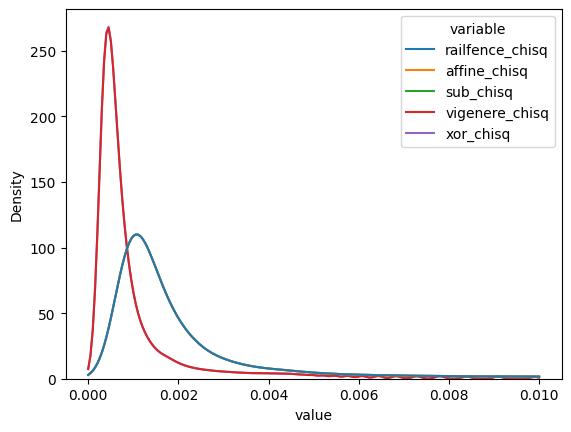

In [27]:
import seaborn as sns

inv_chi_df = df[['railfence_chisq', 'affine_chisq', 'sub_chisq', 'vigenere_chisq', 'xor_chisq']].melt()
sns.kdeplot(inv_chi_df, x='value', hue='variable', clip=(0, .01))

<Axes: xlabel='value', ylabel='Density'>

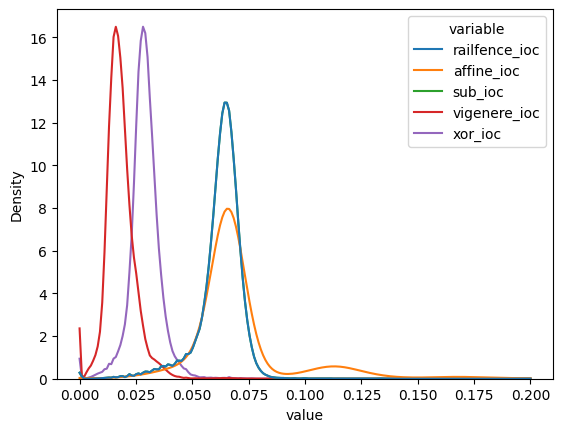

In [28]:
ioc_df = df[['railfence_ioc', 'affine_ioc', 'sub_ioc', 'vigenere_ioc', 'xor_ioc']].melt()
sns.kdeplot(ioc_df, x='value', hue='variable', clip=(0, .2))